In [ ]:
from __future__ import print_function

In [ ]:
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from PIL import Image as Img

from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave

import time

HEIGHT = 512
WIDTH = 512
SHAPE = (WIDTH, HEIGHT)


In [ ]:
style_img_path = 'art.jpg'

In [ ]:
content_img_path = 'Zayn.jpeg'

In [ ]:

# define a func to load images
def load_image(image_path):
    image = Img.open(image_path)
    image = image.resize(SHAPE)
    return image


In [ ]:
# convert images into a form suitable for numerical processing.
def image_to_float(image):
    img_array = np.asarray(image, dtype = 'float32')
    img_array = np.expand_dims(img_array, axis = 0)
    return img_array

In [ ]:

# subtract mean RGB value from each pixel and conver RGB to BGR
def convert_pixels(array):
    array[:, :, :, 0] -= 103.939
    array[:, :, :, 1] -= 116.779
    array[:, :, :, 2] -= 123.68
    return array[:, :, :, ::-1]

In [ ]:
# content loss is euclidean dist bw feature representations of the content and combination loss
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [ ]:
# gram mtrix is computed by reshaping the feature spaces suitably by taking their outer product
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram


In [ ]:
#---style loss---(we use gram matrix)
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = HEIGHT * WIDTH
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# for smootness of image
def total_variation_loss(x):
    a = backend.square(x[:, :HEIGHT - 1, :WIDTH - 1, :]- x[:, 1:, :WIDTH-1, :])
    b = backend.square(x[:, :HEIGHT-1, :WIDTH-1, :] - x[:, :HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))


def eval_loss_and_grads(x):
    x = x.reshape((1, HEIGHT, WIDTH, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

# Evalutor class computes loss and gradients 
class Evaluator(object):
    '''computes loss and Gradients'''
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
        
    def loss(self, x):
       # assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        #assert self.loss_value is None
        grad_values = np.copy(self.grad_values)
        self.loss__value = None
        self.grad_values = None
        return grad_values


In [ ]:
content_image = load_image(content_img_path)
style_image = load_image(style_img_path)

In [ ]:
content_array = image_to_float(content_image)
style_array = image_to_float(style_image)


In [ ]:
print(content_array.shape)

(1, 512, 512, 3)


In [ ]:
print(style_array.shape)

(1, 512, 512, 3)


In [ ]:

content_array = convert_pixels(content_array)


In [ ]:
style_array = convert_pixels(style_array)

In [ ]:
#use the arrays to define variables in keras backend
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)

# introduce placeholder var to store the combination image.
combination_image = backend.placeholder((1, HEIGHT, WIDTH, 3))

# concenrate all the img data into a single tensor that's suitable for processing by Keras's VGG16 model
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis = 0)

# defining our model
model = VGG16(input_tensor = input_tensor, weights = 'imagenet', include_top = False)

# layers in model
layers = dict([(layer.name, layer.output) for layer in model.layers])

# relative importance of content_loss, style_loss and total variation loss
content_weight = 0.025 
style_weight = 5.0
total_variatio_weight = 1.0

# initially total loss will be 0
loss = backend.variable(0.)


In [ ]:
#---content loss---

# we use block2_conv2 layer to get content 
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = content_weight * content_loss(content_image_features,
                                      combination_features)

# total style loss = style_weight per layer * style loss

style_feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for layer in style_feature_layers:
    layer_features = layers[layer]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sty_los = style_loss(style_features, combination_features)
    loss += (style_weight / len(style_feature_layers)) * sty_los
    

# total variation loss - for optimization - for smootness

loss += total_variatio_weight * total_variation_loss(combination_image)

# gradient of the total loss relative to the combination img 

grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, HEIGHT, WIDTH, 3)) - 128

iterations = 10

for _ in range(iterations):
    print('Start of Iteration :-' + str(_))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime = evaluator.grads, maxfun = 20)
    print('Current Loss value :' + str(min_val))
    end_time = time.time()
    print('Iteration %d completed in %ds' % (_, end_time - start_time))
    
# subject output img to the inverse of transformation 
    
x = x.reshape((HEIGHT, WIDTH, 3))
x = x[:, :, ::-1]

x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68

x = np.clip(x, 0, 255).astype('uint8')

Start of Iteration :-0
Current Loss value :86364240000.0
Iteration 0 completed in 14s
Start of Iteration :-1
Current Loss value :60463043000.0
Iteration 1 completed in 13s
Start of Iteration :-2
Current Loss value :52656280000.0
Iteration 2 completed in 14s
Start of Iteration :-3
Current Loss value :49330622000.0
Iteration 3 completed in 14s
Start of Iteration :-4
Current Loss value :47330992000.0
Iteration 4 completed in 14s
Start of Iteration :-5
Current Loss value :46203216000.0
Iteration 5 completed in 14s
Start of Iteration :-6
Current Loss value :45476934000.0
Iteration 6 completed in 14s
Start of Iteration :-7
Current Loss value :45030687000.0
Iteration 7 completed in 14s
Start of Iteration :-8
Current Loss value :44681277000.0
Iteration 8 completed in 14s
Start of Iteration :-9
Current Loss value :44418585000.0
Iteration 9 completed in 14s


In [ ]:
from IPython.display import Image

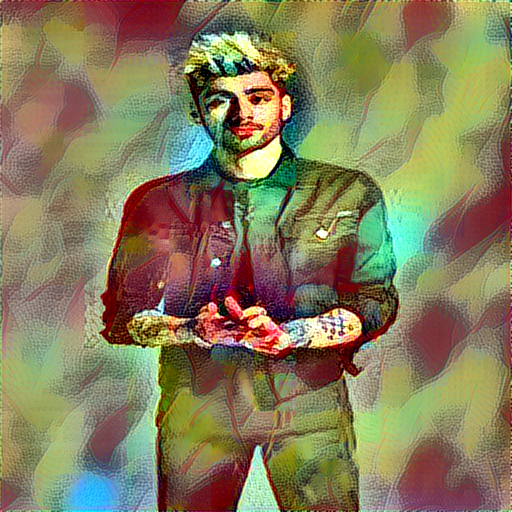

In [ ]:
display(Img.fromarray(x))